# 비정형 데이터를 통한 국내 상장사 연관정보 추출

### NER 알고리즘을 사용한 테마 / 이벤트 단어 추출 
### 연관 기업은 NICE 기업정보를 크롤링하여 본 notebook에는 포함되지 않음
### 연관 단어 추출은 SoyKeyword 오픈소스 라이브러리 사용

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_pandas
import warnings
import re
from collections import Counter, defaultdict

warnings.filterwarnings('ignore')

tqdm.pandas()

In [2]:
from pyhive import hive 
import pandas as pd 
conn = hive.Connection('172.20.8.62', port=10000, username='65223', password='65223q12!', database='lake', auth='LDAP') 
sql = ''' 
select n_date, n_code, n_title, n_content from lake.n_newsmem
where n_fgubun not in ('F05','F12','F22','F38','F39','F40')
and (n_title, n_content) is NOT NULL
and n_code != '000000  '
and n_date > 20210601
''' 
%time news_data = pd.read_sql(sql, conn, parse_dates = ['n_date']) 

CPU times: user 7.22 s, sys: 1.87 s, total: 9.1 s
Wall time: 57.1 s


In [952]:
from pyhive import hive 
import pandas as pd 
conn = hive.Connection('172.20.8.62', port=10000, username='65223', password='65223q12!', database='lake', auth='LDAP') 

sql = ''' 
select RSH_PPR_DRU_DT, RSH_PPR_IEM_CD_PCL, RSH_PPR_IEM_NM_PCL, ems_til_cts, RSH_PPR_CTS_lne_del from lake.tcisr_rsh_ppr 
where rsh_ppr_dru_dt between 20210601 and 20210815
''' 
%time research_data = pd.read_sql(sql, conn, parse_dates = ['rsh_ppr_dru_dt']) 

CPU times: user 71.3 ms, sys: 11.1 ms, total: 82.4 ms
Wall time: 10.4 s


In [710]:
iem_data = pd.read_csv('stk_iem_ifo.csv', sep = '\t', encoding = 'utf-8')

# 분석용 테이블 생성 및 기본 전처리

In [5]:
news_data.drop(news_data.loc[news_data['n_content'].isnull()].index, axis = 0, inplace = True)
news_data.drop(news_data.loc[news_data['n_title'].isnull()].index, axis = 0, inplace = True)
news_data.reset_index(drop = True, inplace = True)

In [711]:
def del_tab(x):
    x = re.sub(' ', '', x)
    return x

iem_data.dropna(axis = 0, inplace = True)
iem_data.reset_index(drop = True, inplace = True)

tqdm.pandas()
iem_data['iem_cd'] = iem_data['iem_cd'].progress_apply(del_tab)
iem_data['iem_cd'] = iem_data['iem_cd'].progress_apply(lambda x : re.sub('A', '', x))
iem_data['stk_iem_krl_nm'] = iem_data['stk_iem_krl_nm'].progress_apply(del_tab)
iem_data['rgs_mkt_cd'] = iem_data['rgs_mkt_cd'].progress_apply(del_tab)

#news_data['n_code'] = news_data['n_code'].progress_apply(del_tab)

100%|██████████| 5454/5454 [00:00<00:00, 201358.49it/s]


In [712]:
iem_data.rename({'iem_cd' : 'n_code'}, axis = 1, inplace = True)

In [8]:
news_data['title_content'] = news_data['n_title'] + '. ' + news_data['n_content']
research_data['title_content'] = research_data['ems_til_cts'] + '. ' + research_data['rsh_ppr_cts_lne_del']

In [708]:
# cleaning code

from bs4 import BeautifulSoup

def text_cleaning_1(text):
    text = re.sub('<a[ _a-zA-Z=\"\']+href.*?>(.*?)<\/a>', ' ', text)
    text = re.sub('<td[ _a-zA-Z=\"\']+.*?>(.*?)<\/td>', ' ', text)
    text = re.sub('<head.*/head>', ' ', text)
    text = re.sub('&[a-zA-Z0-9]+;', ' ', text)
    text = re.sub('<br />', ' ', text)
    # Beautiful Soup 으로 읽으면 어느정도 HTML 태그는 제거 됨  
    text = BeautifulSoup(text).get_text()
    # 중복되는 공백 (2개 이상) 제거 
    text = re.sub('[ ]+', ' ', text)
    return text

def text_cleaning_2(x):
    if len(re.findall('[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z-.]+', x)) > 0:
        x = x.split(re.findall('[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z-.]+', x)[0])[0]
    else:
        pass
    if len(re.findall('VIP', x)) > 0:
        x = 'drop_records'
    else:
        pass
    if len(re.findall('머니투데이', x)) > 0:
        x = 'drop_records'
    else:
        pass
    if len(re.findall('골든클럽', x)) > 0:
        x = 'drop_records'
    else:
        pass
    if len(re.findall('무료체험 신청', x)) > 0:
        x = 'drop_records'
    else:
        pass
    if len(re.findall('바로가기', x)) > 0:
        x = x.split(re.findall('바로가기', x)[0])[0]
    else:
        pass
    if len(re.findall('해당 기사는', x)) > 0:
        x = x.split(re.findall('해당 기사는', x)[0])[0]
    else:
        pass
    if len(re.findall('이 기사는', x)) > 0:
        x = x.split(re.findall('이 기사는', x)[0])[0]
    else:
        pass
    if len(re.findall('자료출처', x)) > 0:
        x = x.split(re.findall('자료출처', x)[0])[0]
    else:
        pass
    if len(re.findall('본 글은 투자 참고용', x)) > 0:
        x = x.split(re.findall('본 글은 투자 참고용', x)[0])[0]
    else:
        pass
    if len(re.findall('Copyright', x)) > 0:
        x = x.split(re.findall('Copyright', x)[0])[0]
    else:
        pass
    if len(re.findall('사진 제공', x)) > 0:
        x = x.split(re.findall('사진 제공', x)[0])[0]
    else:
        pass
    if len(re.findall('급등포착', x)) > 0:
        x = x.split(re.findall('급등포착', x)[0])[0]
    else:
        pass
    x = re.sub('&.+?;', ' ', x)
    x = re.sub('\s+[가-힣]+\s[기]+[자]+',' ', x)
    x = re.sub('서울', ' ', x)
    x = re.sub('연합뉴스', ' ', x)
    x = re.sub('한경닷컴', ' ', x)
    x = re.sub('뉴스룸', ' ', x)
    x = re.sub('파이낸셜뉴스', ' ', x)
    x = re.sub(r'[^\w'+"."+']', ' ', x)
    x = re.sub('[\\t]', ' ', x)
    x = re.sub('ㆍ', ' ', x)
    x = re.sub('nbsp', ' ', x)
    x = re.sub('[ ]+', ' ', x)
    return x

In [69]:
news_data['title_content_clean'] = news_data['title_content'].progress_apply(text_cleaning_1)
news_data['title_content_clean'] = news_data['title_content_clean'].progress_apply(text_cleaning_2)

100%|██████████| 145078/145078 [01:03<00:00, 2285.20it/s]


In [70]:
news_data.drop(news_data.loc[news_data['title_content_clean'] == 'drop_records'].index, axis = 0, inplace = True)
news_data.reset_index(drop = True, inplace = True)

In [71]:
research_data.dropna(axis = 0, inplace = True)
research_data.reset_index(drop = True, inplace = True)

In [72]:
def research_text_cleaning(x):
    x = re.sub('<.+?>', ' ', x)
    x = re.sub('&.+?;', ' ', x)
    return re.sub('[^\w\s]', ' ', x)

In [73]:
research_data['title_content_clean'] = research_data['title_content'].apply(research_text_cleaning)

In [74]:
news_data = pd.merge(iem_data, news_data, on = 'n_code', how = 'right')

In [75]:
news_data.dropna(axis = 0, inplace = True)
news_data.reset_index(drop = True, inplace = True)

In [76]:
multivalue_research_data = research_data.loc[research_data['rsh_ppr_iem_cd_pcl'].str.contains(',')]
research_data.drop(multivalue_research_data.index, axis = 0, inplace = True)
multivalue_research_data.reset_index(drop = True, inplace = True)

In [77]:
# 다중값 종목코드, 종목명 레코드 단위 분리

multi_sep_data = []

for i in range(len(multivalue_research_data)):
    for j in range(100):
        try:
            date = multivalue_research_data['rsh_ppr_dru_dt'][i]
            code = multivalue_research_data['rsh_ppr_iem_cd_pcl'][i].split(',')[j]
            name = multivalue_research_data['rsh_ppr_iem_nm_pcl'][i].split(',')[j]
            title = multivalue_research_data['ems_til_cts'][i]
            content = multivalue_research_data['rsh_ppr_cts_lne_del'][i]
            title_clean = multivalue_research_data['ems_til_cts_clean'][i]
            content_clean = multivalue_research_data['rsh_ppr_cts_clean'][i]
            
            data = date, code, name, title, content, title_clean, content_clean
            multi_sep_data.append(data)
        except:
            continue

In [78]:
multivalue_research_data = pd.DataFrame(multi_sep_data, columns = research_data.columns)

In [79]:
research_data = pd.concat([research_data, multivalue_research_data], axis = 0)

In [80]:
research_data.rename({'rsh_ppr_iem_cd_pcl' : 'n_code'}, axis = 1, inplace = True)

In [81]:
research_data = pd.merge(iem_data, research_data, on = 'n_code', how = 'right')

In [82]:
research_data.dropna(axis = 0, inplace = True)

In [83]:
research_data.drop(['rsh_ppr_iem_nm_pcl'], axis = 1, inplace = True)

In [84]:
research_data.rename({'rsh_ppr_dru_dt' : 'n_date',
                      'ems_til_cts': 'n_title',
                      'ems_til_cts_clean' : 'n_title_clean',
                     'rsh_ppr_cts_lne_del' : 'n_content',
                     'rsh_ppr_cts_clean' : 'n_content_clean'}, axis = 1, inplace = True)

In [85]:
news_data['form'] = 'news'
research_data['form'] = 'research'

In [86]:
data = pd.concat([news_data, research_data], axis = 0)

In [87]:
data.reset_index(drop = True, inplace = True)
data.shape

(134719, 10)

In [88]:
data['month'] = data['n_date'].dt.month
data['day'] = data['n_date'].dt.day
data['dayofweek'] = data['n_date'].dt.dayofweek

In [89]:
%%time
data.to_csv('new_metadata.csv',index = False)

CPU times: user 1min 11s, sys: 1.9 s, total: 1min 13s
Wall time: 1min 14s


In [221]:
cd ./INTERN2021_Python/hyp

/home/65223/INTERN2021_Python/hyp


In [4]:
%%time
metadata = pd.read_csv('new_metadata.csv')

CPU times: user 43.4 s, sys: 5.62 s, total: 49.1 s
Wall time: 51.6 s


# 사용자 사전 정의

In [57]:
cd ./INTERN2021_Python/hyp

/home/65223/INTERN2021_Python/hyp


In [689]:
from konlpy.tag import Mecab

mecab = Mecab('/home/65223/mecab_new/mecab-ko-dic-2.1.1-20180720')

In [826]:
df_theme = pd.read_csv('테마.csv')
df_sector = pd.read_csv('sector.txt', sep = '\t')
df_kospi = pd.read_csv('kospi.txt', sep = '\t')
df_kosdaq = pd.read_csv('kosdaq.txt', sep = '\t')
stk_mk_words = pd.read_csv('stk_mk_words.txt', sep = '\t')

In [60]:
extra_words = ['선물거래', '현물거래', '동학개미', '서학개미', '동학개미운동', '서학개미운동',
              '주도주', '동전주', '지폐주', '품절주', '테마주', '종목명', '스윙', 'PER', 'PBR', '따상',
              '따따상', '쩜상', '쩜하', '시총', '투자주의', '투자경고', '코스피', '코스닥',
              '이데일리', '머니투데이', '연합뉴스', '인포스탁', '매일경제', '한경닷컴', 'FICC', '투자전략', '해외주식',
               '자산관리', '아시아경제', '뉴스핌', '파이낸셜', '이투데이', '헤럴드경제', '조선경제', '모닝미팅브리프', '서울경제',
               '코넥스', 'NSP통신', '금현물', '채권공시', '타임앤포인트', 'IR GO', '아이투자', '연합뉴스', '톰슨로이터',
              '기계·장비', '금융', '반도체', '통신장비', '운송장비·부품', '방송서비스', '유통', '제약',
               '디지털컨텐츠', '화학', '기타서비스', '건설', '섬유·의류', '일반전기전자', '오락·문화', '금속',
               '소프트웨어', 'IT부품', '출판·매체복제', '기타제조', '비금속', '인터넷', '정보기기', '음식료·담배',
               '종이·목재', '의료·정밀기기', '통신서비스', '농업, 임업 및 어업', '컴퓨터서비스', '숙박·음식',
               '운송', '광업', '전기·가스·수도', '서비스업', '기타금융', '유통업', '섬유의복', '운수창고업',
               '음식료품', '증권', '보험', '전기전자', '건설업', '철강금속', '기계', '의약품', '비금속광물',
               '운수장비', '통신업', '기타제조업', '전기가스업', '종이목재', '은행', '의료정밀', '관련주', '2차전지',
               '신규상장', '농업','은행','코로나19', '남북경협', '태풍 및 장마', '비료', 'mRNA', '사료', '백화점',
               '영화', 'K-뉴딜지수', '카카오뱅크 관련주', '바이오시밀러', '모바일솔루션', '아스콘', '日 수출 규제', '구충제',
               '조림사업', '온실가스', '제대혈','가상현실', '아프리카 돼지열병', '면세점', '핵융합에너지', '슈퍼박테리아',
               '시멘트', '레미콘', '백신','진단시약', '음원', '음반', '음성인식', '엔터테인먼트', '항공', '저가 항공사',
               '원자력발전소 해체', '콜드체인', '항공기부품', '증강현실', '육계', 'GTX', 'PCB', '2차전지', '해저터널', '패션',
               '의류', '골프', '테마파크', '수소차', '치매', '3D 낸드', '희귀금속', '제약업체', '공작기계', '스마트팩토리', '전자파',
               '우주항공산업', '셰일가스', '터치패널','반도체 재료', '부품', '플렉서블 디스플레이', '해운', '태블릿PC',
               '메르스 코로나 바이러스', '토스 관련주', '스포츠행사 수혜', '편의점', '구제역', '광우병 수혜', '전력저장장치',
               '여행', '소모성자재구매대행', '3D 프린터', '보톡스', '음식료업종', '인터넷은행', '전자결제', '강관업체', '제4이동통신',
               '화장품', 'SSD', '건설기계', '기업인수목적회사', 'OLED', '원자력발전', '줄기세포', '클라우드 컴퓨팅',
               '무선충전기술', '그래핀','LCD 부품', '소재', '고령화 사회','수자원', 'LNG', '모바일콘텐츠', '사물인터넷',
               '전기차', '日제품 불매운동', '폴더블폰', '비철금속', '수산', '증권', '리츠', '자율주행차', '제지', '갤럭시 부품주',
               '건강기능식품', 'LCD장비', '환율하락 수혜', '아이폰', 'U-Healthcare', '게임', '건설 중소형', '소매유통', '지주사',
               '선박평형수 처리장치', '스마트홈', '여름', '풍력에너지', '겨울', '두나무 관련주', '마리화나', 'CCTV＆DVR',
               '신규상장', '영상콘텐츠', '건설 대표주', 'MLCC', '스마트폰', '황사', '미세먼지', '모바일게임', '광고', '주류업',
               '보안주', 'NI', '페인트', '키오스크', '태양광에너지', '석유화학', '손해보험', '철강 중소형','국내 상장 중국기업',
               '자동차 대표주', '스마트카', '반도체 장비', '차량용블랙박스', '생명보험', '삼성페이', '밥솥', '전기자전거', '조선기자재',
               '도시가스', '지능형로봇', '인공지능', '방위산업', '전쟁 및 테러', '반도체 대표주', '유전자 치료제', '분석', '자동차부품',
               '의료기기', '통신', '치아 치료', '핀테크', '바이오인식', '남-북-러 가스관사업', '시스템반도체', '화학섬유', '타이어',
               '자원개발', 'LPG', '홈쇼핑', '휴대폰부품', 'DMZ 평화공원', 'LED', '화폐', '금융자동화기기', '북한 광물자원개발',
               '야놀자 관련주', '재난', '안전', '가상화폐', '조선', '리모델링', '인테리어', '면역항암제', 'LCD BLU제조',
               '4차산업 수혜주', '폐기물처리', '마켓컬리 관련주', '종합상사','SI', '정유', '마스크', '철강 주요종목', '5G', '종합 물류',
               '제습기', '캐릭터상품', '쿠팡 관련주', '창투사', 'LED장비', '메타버스', '공기청정기', '카메라모듈', '부품', 'IT 대표주',
               '2019 상반기신규상장', 'SNS', '블록체인', '자전거', '스마트그리드', '통신장비', '골판지 제조', '엔젤산업', '미디어',
               'MVNO', '인터넷대표주', '웹툰', '재택근무','스마트워크', '마이크로 LED', '출산장려정책', '4대강 복원', '드론',
               '케이블TV SO', 'MSO', '교육', '온라인 교육', '전력설비', '백신여권', '탄소나노튜브', '일자리', '전선', 'RFID',
               '크래프톤 관련주', '카지노', 'ODM', 'OEM','수혜주', '관련주', '2차전지', '이차전지', '카카오택시', 
               '카카오 택시', '카카오모빌리티', '카카오 모빌리티', '카카오 뱅크',
               '카카오뱅크', '카카오웹툰', '카카오프렌즈','갤럭시S11',
               '갤럭시폴드','갤럭시 플립', '갤럭시플립',  '카카오페이', '카카오게임즈', 
               '카카오엔터프라이즈', '크래프톤', '배틀그라운드',  '테이퍼링',
               'NH투자증권', '엔비디아', '게이밍노트북', '울트라기어', '디오스', 'DIOS', '휘센',
              'WHISEN', '트롬', 'TROMM', '퓨리케어', 'PuriCare', '코드제로', 'CordZero', '디램', 'DRAM', 'NAND', '낸드',
              'QLED', '큐엘이디', '아몰레드', 'AMOLED', '인피니티 디스플레이', '비스포크', '무풍에어컨', '오디세이',
              '갤럭시 워치', '갤럭시워치', '갤럭시버즈', '갤럭시 버즈', '컨버터블 PC', '컨버터블PC', '스마트싱스', '스마트띵스',
              'SmartThings', '기어360', '기어 360', 'LG에너지솔루션', 'LG이노텍', 'SK바이오사이언스', 'SK아이이테크', 'SK아이이테크놀로지',
              'SK디앤디', 'SKD&D', 'SKC', 'SK디스커버리', 'SKC솔믹스', 'SK하이닉스', 'SK렌터카', 'PSK', 'SK바이오팜','SK커뮤니케이션',
               'DSK', 'SK브로드밴드', 'PSK홀딩스', 'SK머티리얼즈']

In [61]:
extra_words = pd.DataFrame(extra_words, columns = ['words'])
stk_mk_words['words'] = stk_mk_words['words'].apply(lambda x:x.split('(')[0])
stk_mk_words = pd.concat([stk_mk_words, extra_words], axis = 0)

theme_name = df_theme[['테마이름']]
theme_name.rename({'테마이름' : 'words'}, axis = 1, inplace = True)
df_sector.rename({'업종명' : 'words'}, axis = 1, inplace = True)
df_kospi.rename({'코스피' : 'words'}, axis = 1, inplace = True)
df_kosdaq.rename({'코스닥' : 'words'}, axis = 1, inplace = True)

stk_mk_words = pd.concat([stk_mk_words, theme_name], axis = 0)
stk_mk_words = pd.concat([stk_mk_words, df_sector], axis = 0)
stk_mk_words = pd.concat([stk_mk_words, df_kospi], axis = 0)
stk_mk_words = pd.concat([stk_mk_words, df_kosdaq], axis = 0)

stk_mk_words.drop_duplicates(['words'], inplace = True)
stk_mk_words.reset_index(drop = True, inplace = True)

In [62]:
for i in range(len(stk_mk_words['words'])):
    stk_mk_words['words'][i] = re.sub(' ', '', stk_mk_words['words'][i])
    stk_mk_words['words'][i] = re.sub(',', '', stk_mk_words['words'][i])

In [64]:
cd ..

/home/65223


In [65]:
cd ./mecab_new/mecab-ko-dic-2.1.1-20180720

/home/65223/mecab_new/mecab-ko-dic-2.1.1-20180720


In [66]:
with open("./user-dic/nnp.csv", 'r', encoding='utf-8') as f:
    file_data = f.readlines()

In [67]:
file_data

['대우,,,,NNP,*,F,대우,*,*,*,*,*\n', '구글,,,,NNP,*,T,구글,*,*,*,*,*\n']

In [68]:
!pip install jamo

Looking in indexes: http://172.20.8.21:8081/repository/pypi-repo/simple


In [69]:
from jamo import h2j, j2hcj 

def get_jongsung_TF(sample_text): 
    sample_text_list = list(sample_text) 
    last_word = sample_text_list[-1] 
    last_word_jamo_list = list(j2hcj(h2j(last_word))) 
    last_jamo = last_word_jamo_list[-1] 
    
    jongsung_TF = "T" 
    
    if last_jamo in ['ㅏ', 'ㅑ', 'ㅓ', 'ㅕ', 'ㅗ', 'ㅛ', 'ㅜ', 'ㅠ', 'ㅡ', 'ㅣ', 'ㅘ', 'ㅚ', 'ㅙ', 'ㅝ', 'ㅞ', 'ㅢ', 'ㅐ,ㅔ', 'ㅟ', 'ㅖ', 'ㅒ']: 
        jongsung_TF = "F" 
        
    return jongsung_TF

In [70]:
with open("./user-dic/nnp.csv", 'r', encoding='utf-8') as f: 
    file_data = f.readlines() 
    
word_list = list(stk_mk_words['words'])

for word in word_list: 
    jongsung_TF = get_jongsung_TF(word) 
    
    line = '{},,,,NNP,*,{},{},*,*,*,*,*\n'.format(word, jongsung_TF, word) 
    
    file_data.append(line)

In [71]:
with open("./user-dic/nnp.csv", 'w', encoding='utf-8') as f:
    for line in file_data:
        f.write(line)

In [72]:
with open("./user-dic/nnp.csv", 'r', encoding='utf-8') as f:
    file_new = f.readlines()
    
file_new

['대우,,,,NNP,*,F,대우,*,*,*,*,*\n',
 '구글,,,,NNP,*,T,구글,*,*,*,*,*\n',
 '10%휠터룰,,,,NNP,*,T,10%휠터룰,*,*,*,*,*\n',
 'BLUECHIP의요건,,,,NNP,*,T,BLUECHIP의요건,*,*,*,*,*\n',
 'BMF,,,,NNP,*,T,BMF,*,*,*,*,*\n',
 'M1M2M3,,,,NNP,*,T,M1M2M3,*,*,*,*,*\n',
 'MIP,,,,NNP,*,T,MIP,*,*,*,*,*\n',
 'OBV지표,,,,NNP,*,F,OBV지표,*,*,*,*,*\n',
 'OBV지표의해석,,,,NNP,*,T,OBV지표의해석,*,*,*,*,*\n',
 'OBV지표로본매매시점포착방법,,,,NNP,*,T,OBV지표로본매매시점포착방법,*,*,*,*,*\n',
 'Q비율,,,,NNP,*,T,Q비율,*,*,*,*,*\n',
 '가격역지정주문,,,,NNP,*,T,가격역지정주문,*,*,*,*,*\n',
 '가격우선의원칙,,,,NNP,*,T,가격우선의원칙,*,*,*,*,*\n',
 '가수급,,,,NNP,*,T,가수급,*,*,*,*,*\n',
 '가장매매,,,,NNP,*,T,가장매매,*,*,*,*,*\n',
 '간사회사,,,,NNP,*,F,간사회사,*,*,*,*,*\n',
 '감가상각,,,,NNP,*,T,감가상각,*,*,*,*,*\n',
 '감리종목,,,,NNP,*,T,감리종목,*,*,*,*,*\n',
 '감사의견,,,,NNP,*,T,감사의견,*,*,*,*,*\n',
 '감사증명,,,,NNP,*,T,감사증명,*,*,*,*,*\n',
 '개방형수익증권,,,,NNP,*,T,개방형수익증권,*,*,*,*,*\n',
 '개별경쟁매매,,,,NNP,*,T,개별경쟁매매,*,*,*,*,*\n',
 '갱생주가,,,,NNP,*,F,갱생주가,*,*,*,*,*\n',
 '거래량이동평균선,,,,NNP,*,T,거래량이동평균선,*,*,*,*,*\n',
 '거래량,,,,NNP,*,T,거래량,*,*,*,*,*\n',
 '거래량회전율,

In [73]:
mecab = Mecab()
mecab.pos('전고체배터리')

[('전고체배터리', 'NNP')]

# Tokenize (Mecab)

In [690]:
stopword_list = ['종목', '관련', '투자', '돋움', '주식', '사업', '확인', '대비', '무료', '사업', '기사', '무료공개',
                 '매수', '원샷', '주가', '고공', '행진', '지금', '당장', 'TOP', '체험', '입장', '카톡방', '카톡',
                '주린이', '린이', '리딩', '리딩방', '평생', '초대형', '株', '클릭', '급등', '임박', '추천', '추천주',
                '정보', '신청', '즉시', '비공개', '폭등', '폭등주', '시선', '집중', '추매', '추매각', '포착', '테마',
                '황제', '대장', '황제주', '대장주', '무료리딩방', '무단', '전재', '배포', '뉴스', '재물운', '재물',
                 '추석', '순매수', '상승', '개발', '기사', '책임', '증권', '최근', '영업', '시장', '제공', '기준', '분석',
                 '전문', '뉴스봇', '테마', '개요', '리스트', '설명', '자료', '인포스탁', '홈페이지', '로보뉴스', '알고리즘', '씽크풀',
                 '작성', '공동', '기업', '급난', '필라델피아', '인스트', '오스틴', '금액주', '코아시아', '법위', '송심', '기환',
                 '비스', '국정','농단', '유족', '준법', '징역', '선고', '팔자', '어치', '사자', '마감', '거래량회전율', '기자', 
                 '박상인','박흥순', '이종무', '결강', '매도우', '서경', '이도원', '규빈', '윤서연', '김호윤', '표준편차', '김민주',
                 '이근우', '김혜영', '김수정', '화영', '일보', '박준영', '서청석', '이코', '비업', '코노', '요한',
                 '지디', '학업', '분전', '우위', '리뷰', '강도', '수집', '반전', '시각', '회전율', '천주', '기록', '저작', '매체',
                 '길드', '던전', '스킬', '소환', '몬스터', '미션', '쿠키', '퀘스트', '레이드', '보스', '나이츠', '벤트', '전설',
                 '아이템', '응모', '업데이트', '전투', '아레나', '영웅', '쿠폰', '경품', '이용자', '구단', '번역', '유저',
                 '감상', '오브', '스테이지', '오디션', '로그인', '멘토링', '야구', '맞손', '우대', '클래식', '마감', '적중',
                 '오랫동안', '팔자', '스탠더드', '세력', '선착순', '다운', '외인', '파월', '집중투자', '금일', '고수', '앤드',
                 '부양책', '어스', '후회', '동사', '인원', '선착순', '하루', '코드', '한시', '최강', '회주', '횟수', '무제',
                 '이용료', '승률', '발췌', '침조', '정렬', '분간', '주순', '역대', '이미지', '단독', '번주', '매일', '박주'
                 '대어', '래프', '월간', '비즈', '기환', '지위', '본건', '관사', '이지', '상단', '에이', '구독자', '데드', '에어',
                 '특급', '아침', '오전', '오후', '질주', '헤럴드경제', '대환', '수전', '탁론', '드립', '대중', 
                 '한정', '박찬구', '슈퍼', '형제','미수', '이젠', '프리미엄', '긴급', '박철완', '관세', '스탁', '인기', 
                 '트림', '시대', '바이', '스크랩', '이것','최저', '초보', '모터쇼', '유수', '박정호', '평택', '리더십', '플라이']

# 불용어 제거 함수
def remove_stopwords(words):
    result = []
    for w in words:
        if w not in stopword_list:
            result.append(w)
    return result

# 한 글자 단어 제거 함수
def remove_onewords(words):
    result = []
    for w in words:
        if len(w) != 1:
            result.append(w)
    return result

drop_tagger = ['SC','SE','SF','SH','SN','SSC','SSO','SY']

def unigram_tokenizer(raw_text):
    unigram = [word for word,pos in mecab.pos(raw_text) if pos not in drop_tagger and word not in stopword_list and len(word) != 1]
    return unigram

In [154]:
metadata['token'] = metadata["title_content_clean"].progress_apply(unigram_tokenizer)

100%|██████████| 134719/134719 [08:08<00:00, 275.84it/s]


In [156]:
random_sample = metadata.sample(frac = 1).reset_index(drop = True)

In [158]:
sep_token = []

for i in tqdm(range(len(random_sample))):
    for j in range(200):
        try:
            text_id = 'text_{}'.format(i)
            n_code = random_sample['n_code'][i]
            name= random_sample['stk_iem_krl_nm'][i]
            token = random_sample['token'][i][j]
            
            token_data = text_id, n_code, name, token
            sep_token.append(token_data)
        except:
            continue

100%|██████████| 134719/134719 [34:53<00:00, 64.36it/s]


In [159]:
NER_data = pd.DataFrame(sep_token, columns = ['id','n_code', 'name', 'token'])

In [959]:
NER_data.head()

In [161]:
NER_data['BIO_tag'] = 'O'

In [163]:
NER_data.to_csv('NER_dataset.csv', index = False)

# NER Labeling

In [164]:
NER_data = pd.read_csv('NER_dataset.csv')

In [827]:
kospi_comp_list = list(df_kospi['코스피'].unique())
kosdaq_comp_list = list(df_kosdaq['코스닥'].unique())

for i in range(len(df_theme['테마이름'])):
    df_theme['테마이름'][i] = re.sub(' ', '', df_theme['테마이름'][i])
theme_name_list = list(df_theme['테마이름'].unique())

In [166]:
import multiprocessing as mp
from multiprocessing import Pool
import time

# 기업명 리스트에 있는 토큰은 기업명 태깅
def basic_labeling(x):
    if x in kospi_comp_list:
        return 'B_COMP'
    elif x in kosdaq_comp_list:
        return 'B_COMP'
    # 나머지는 전부 O 태깅
    else:
        return 'O'
    
def apply_labeling(data):
    data['BIO_tag'] = data['token'].progress_apply(lambda x : basic_labeling(x))
    return data
    
def parallel_df(df,func,n_cores):
    df_split = np.array_split(df,n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

start = int(time.time())

# Multiprocessing
df = parallel_df(NER_data,apply_labeling,n_cores=50)

# 연산 소요시간 측정
print(int(time.time() - start))

NER_data = df

100%|██████████| 294753/294753 [00:44<00:00, 6566.55it/s] 


89


In [168]:
NER_data.to_csv('NER_dataset_base_labeled.csv', index = False)

In [169]:
NER_data = pd.read_csv('NER_dataset_base_labeled.csv')

In [828]:
# 이벤트 rule
# 정의해 놨던 Rule을 중간에 날려먹어서 최대한 복구하였습니다..

event_uni_list = ['무상증자', '유상증자', '구조조정', '인수합병', '인플레이션', '신규상장', '대호황', '초호황']


event_head_list = ['MOU', '진출', '계약', '인수', '신증설', 'FOMC', '흥행', 
                 '계약',  '분할', '무상증자', '유상증자', '배당', '구조조정', '병합', '인수', '인플레이션', 
                  '파산', '호황', '신규상장', '초호황', '대호황', '업계'
                 '실적',  '공급', '흡수', '상호', '실적', '공장', '전략', '공급',
                     '법안', '세금', '코인', '임원', '수급', '국내', '해외', '코로나19', '수입', '수출', '서비스', '정식',
                     '무상', '유상', '임상', '코로나', '신규', '코스피', '코스닥', '업종', '사명',
                     '사채', '특허', '자사주', '신제품', '신규', '사업', '수익', '공시', '이벤트',
                     '협약', '성과', '흥행', '출시', '일정']


event_tail_list = ['부진', '발표', '체결', '계약', '합병', '변경', '회복', '결정', '신설', '건설', '완공', '지연',
                     '제휴', '증가', '보수', '인상', '통과', '게이트', '연루', '영향', '문제', '감소', '확산', '시작',
                     '판매', '서비스', '계약 ', '분할', '병합', '인수', '파산', '위기', '성공', '실패', '호황',
                      '수급', '철회', '연기','해결', '요구', '요청', '증자', '예정', '실험', '상장', '추가', '개선',
                      '공개', '대폭', '발주', '프로젝트', '발주', '수주', '발행', '개설', '취득', '특허', '매입', '개발',
                     '편입', '지정', '종목', '규제', '강화', '약화', '악화', '정리', '개편', '구조', '추진', '확대', '확보',
                     '매각', '주력', '달성', '실시','코로나19', '수입', '수출', '서비스', '정식',
                     '무상', '유상', '임상', '코로나', '신규', '코스피', '코스닥', '상장', '추가', '업종', '사명', '추가',
                     '사채', '특허', '자사주', '신제품', '신규', '관리', '규제', '사업', '수익', '공시', '이벤트',
                  '체결', '추진', '보수', '증가', '감소', '시작', '발표', '예정', '성공', '실패', '시작', '철회',
                      '연기', '해결', '요구', '요청', '병합', '인수', '실험', '상장', '추가', '개선', '발주', '수주',
                      '계약', '취득', '지정', '강화', '약화', '악화', '개발', '개설', '정리', '개편', '확보','부진', '발표',
                       '체결', '계약', '합병', '변경', '회복', '결정', '신설', '건설', '완공', '지연',
                     '제휴', '증가', '보수', '인상', '통과', '게이트', '연루', '영향', '문제', '감소', '확산', '시작',
                     '판매', '서비스', '계약 ', '분할', '병합', '인수', '파산', '위기', '성공', '실패', '호황',
                      '수급', '철회', '연기','해결', '요구', '요청', '증자', '예정', '실험', '상장', '추가', '개선',
                      '공개', '대폭', '발주', '프로젝트', '발주', '수주', '발행', '개설', '취득', '특허', '매입', '개발',
                     '편입', '지정', '종목', '규제', '강화', '약화', '악화', '정리', '개편', '구조', '추진', '확대', '확보',
                     '매각', '주력', '달성', '실시','코로나19', '수입', '수출', '서비스', '정식',
                     '무상', '유상', '임상', '코로나', '신규', '코스피', '코스닥', '상장', '추가', '업종', '사명', '추가',
                     '사채', '특허', '자사주', '신제품', '신규', '관리', '규제', '사업', '수익', '공시', '이벤트', '확정']

# 테마 rule

theme_uni_list = ['제약', '의료기기', '이차전지', '금속업', '금융업', '운수장비', '종이목재', '의약품', '전기가스업',
                 '비금속광물', '방송서비스', '모바일게임', '국방', '코로나', '코로나19', '자동차부품', '재생에너지',
                 '신재생에너지', '친환경', '대선','중국', '첨단', '종이', '디지털', '차량', '유망', '우주', '희귀', '코로나', '코로나19',
                 '운송', '백신','의료', '폐수', '재생', '신재생', '친환경', '차량용', '메모리', '비메모리', '이재명', '윤석열', '이준석',
                  '총선', '대선', '테이퍼링', '금리', '원자력']

theme_uni_list = theme_uni_list + theme_name_list

theme_bi_tail_list = ['발전소', '질환', '치료제', '백신', '인프라', '운송','보관', '기기', '처리', '에너지', '관련주', '테마주', '인상', '상승']


# 지속 추가 (모델 디벨롭)


In [829]:
from itertools import product

len(list(product(theme_uni_list, theme_bi_tail_list)))

9436

In [171]:
event_tail_list = list(set(event_tail_list))

In [172]:
import multiprocessing as mp
from multiprocessing import Pool
import time
from itertools import product
from functools import partial
def Rule_based_NER_labeling(i):
        # 이벤트 n-gram lableing
        if NER_data['token'][i] in event_head_list and NER_data['token'][i+1] in event_tail_list:
            NER_data['BIO_tag'][i] = 'B_EVT'
            NER_data['BIO_tag'][i + 1] = 'I_EVT'
        elif NER_data['token'][i] in event_head_list:
            NER_data['BIO_tag'][i] = 'B_EVT'
           
        # 기업명 n-gram labeling
#         if NER_data['token'][i] in comp_bi_head_list and NER_data['token'][i+1] in comp_bi_tail_list:
#             NER_data['BIO_tag'][i] = 'B_COMP'
#             NER_data['BIO_tag'][i + 1] = 'I_COMP'
#         elif NER_data['token'][i] in comp_uni_list:
#             NER_data['BIO_tag'][i] = 'B_COMP'
           
        # 테마 n-gram labeing
        if NER_data['token'][i] in theme_uni_list and NER_data['token'][i+1] in theme_bi_tail_list:
            NER_data['BIO_tag'][i] = 'B_THM'
            NER_data['BIO_tag'][i + 1] = 'I_THM'
        elif NER_data['token'][i] in theme_uni_list:
            NER_data['BIO_tag'][i] = 'B_THM'
       
        else:
            pass
       
        return NER_data

# For loop 용 Multiprocessing (코드 수정 필요)           
if __name__ == '__main__':
    start = time.time()
    pool = Pool(processes=10)
    result = pool.map(Rule_based_NER_labeling, tqdm(range(0, len(NER_data) - 2)))
    end = time.time()
    print("수행시간: %f 초" % (end - start))

100%|██████████| 14737675/14737675 [1:18:25<00:00, 3132.23it/s]  


수행시간: 6337.619494 초


Process ForkPoolWorker-159:
Process ForkPoolWorker-158:
Process ForkPoolWorker-154:
Process ForkPoolWorker-157:
Process ForkPoolWorker-151:
Process ForkPoolWorker-156:
Process ForkPoolWorker-153:
Traceback (most recent call last):
Process ForkPoolWorker-155:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in 

In [177]:
NER_train = result[0]

In [178]:
NER_train['BIO_tag'].value_counts()

O         13696840
B_COMP     1009183
B_THM        16332
B_EVT        12689
I_EVT         2291
I_THM          342
Name: BIO_tag, dtype: int64

In [179]:
NER_train.to_csv('NER_train.csv', index = False)

# NER Modeling

## BiLSTM + CRF
### test1. Fasttext Embedding (OOV 해결 but 성능 저하)
### test2. Pos Embedding(성능 저하)

https://www.kaggle.com/xwalker/cnn-bilstm-crf

https://github.com/keras-team/keras-contrib

In [52]:
# CRF 레이어 설치

cd ./keras-contrib-master

/home/65223/INTERN2021_Python/hyp/keras-contrib-master


In [54]:
!sudo python setup.py install

running install
running bdist_egg
running egg_info
writing keras_contrib.egg-info/PKG-INFO
writing dependency_links to keras_contrib.egg-info/dependency_links.txt
writing requirements to keras_contrib.egg-info/requires.txt
writing top-level names to keras_contrib.egg-info/top_level.txt
reading manifest file 'keras_contrib.egg-info/SOURCES.txt'
writing manifest file 'keras_contrib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/keras_contrib
copying build/lib/keras_contrib/__init__.py -> build/bdist.linux-x86_64/egg/keras_contrib
creating build/bdist.linux-x86_64/egg/keras_contrib/activations
copying build/lib/keras_contrib/activations/__init__.py -> build/bdist.linux-x86_64/egg/keras_contrib/activations
copying build/lib/keras_contrib/activations/squash.py -> build/bdist.linux-x86_64/egg/keras_contrib/activations
creating build/bdist.linux-x86_6

In [58]:
!pip install seqeval

Looking in indexes: http://172.20.8.21:8081/repository/pypi-repo/simple


In [31]:
from sklearn.preprocessing import StandardScaler
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Bidirectional, MaxPooling1D, Reshape, Flatten, Conv1D, Concatenate, TimeDistributed
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text as keras_text, sequence as keras_seq
from keras.callbacks import Callback, ModelCheckpoint
from gensim.models.fasttext import FastText
from gensim.models import Word2Vec
import pickle
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy
from seqeval.metrics import f1_score, classification_report

Using TensorFlow backend.


In [32]:
# Multiclass F1 스코어

class F1score(Callback):
    def __init__(self, value = 0.0, use_char=True):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char

    def sequences_to_tags(self, sequences): 
        result = []
        for sequence in sequences: 
            tag = []
            for pred in sequence: 
                pred_index = np.argmax(pred) 
                tag.append(idx2tag[pred_index].replace("<PAD>", "0")) 
            result.append(tag)
        return result

    def on_epoch_end(self, epoch, logs={}):
        if self.use_char:
            X_test = self.validation_data[0]
            X_char_test = self.validation_data[1]
            y_test = self.validation_data[2]
            y_predicted = self.model.predict([X_test, X_char_test])
        else:
            X_test = self.validation_data[0]
            y_test = self.validation_data[1]
            y_predicted = self.model.predict([X_test])
        
        pred_tags = self.sequences_to_tags(y_predicted)
        test_tags = self.sequences_to_tags(y_test)
        
        score = f1_score(pred_tags, test_tags)
        print(' - f1: {:04.2f}'.format(score * 100))

        if score > self.value:
            print('f1_score improved from %f to %f, saving model to best_model.h5'%(self.value, score))
            self.model.save('best_model.h5')
            self.value = score
        else:
            print('f1_score did not improve from %f'%(self.value))

In [960]:
NER_train = pd.read_csv('NER_train.csv')

In [208]:
NER_train['BIO_tag'].value_counts()

O         13696840
B_COMP     1009183
B_THM        16332
B_EVT        12689
I_EVT         2291
I_THM          342
Name: BIO_tag, dtype: int64

In [209]:
NER_train.dropna(axis = 0, inplace = True)
NER_train.reset_index(drop = True, inplace = True)

In [210]:
# 토큰, BIO태그 정수 인코딩

from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['token'].to_list()))
    else:
        vocab = list(set(data['BIO_tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(NER_train, 'token')
tag2idx, idx2tag = get_dict_map(NER_train, 'tag')

tag2idx['<PAD>'] = 6
idx2tag[6] = '<PAD>'

In [211]:
NER_train['Word_idx'] = NER_train['token'].map(token2idx)
NER_train['Tag_idx'] = NER_train['BIO_tag'].map(tag2idx)
NER_train.head()

,id,n_code,name,token,BIO_tag,Word_idx,Tag_idx
0,text_0,049470,에스지에이,묻어두,O,75007,0
1,text_0,049470,에스지에이,된다,O,64674,0
2,text_0,049470,에스지에이,이종목,O,73106,0
3,text_0,049470,에스지에이,사라,O,79124,0
4,text_0,049470,에스지에이,두산중공업,B_COMP,32314,5


In [212]:
data_fillna = NER_train.fillna(method='ffill', axis=0)

data_group = data_fillna.groupby(
['id', 'n_code', 'name'],as_index=False
)['token','BIO_tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))
# Visualise data
data_group.head()

,id,n_code,name,token,BIO_tag,Word_idx,Tag_idx
0,text_0,049470,에스지에이,"[묻어두, 된다, 이종목, 사라, 두산중공업, 속주, 무조건, 터지, 하나, 습니다...","[O, O, O, O, B_COMP, O, O, O, O, O, O, O, B_EV...","[75007, 64674, 73106, 79124, 32314, 18717, 641...","[0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, ..."
1,text_1,026150,특수건설,"[특수건설, 확대, 특수건설, 확대, 전일, 거래, 특수, 건설, 연관, 대양전기공...","[B_COMP, O, B_COMP, O, O, O, O, B_THM, O, B_CO...","[62613, 17157, 62613, 17157, 56016, 66517, 460...","[5, 0, 5, 0, 0, 0, 0, 1, 0, 5, 5, 5, 5, 5, 5, ..."
2,text_10,086520,에코프로,"[에코프로, 신고, 에코프로, 당일, 까지, 오르, 신고, 현재, 에코프로, 증권사...","[B_COMP, O, B_COMP, O, O, O, O, O, B_COMP, O, ...","[50172, 23517, 50172, 52435, 60599, 34424, 235...","[5, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, ..."
3,text_100,017670,SK텔레콤보통주,"[5G, 집단, 소송, 변론, 기일, 열려, 소송인, SKT, 위반, 제목, 5G,...","[B_THM, O, O, O, O, O, O, O, O, O, B_THM, O, O...","[37448, 33768, 70178, 77966, 27120, 9510, 6538...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,text_1000,030210,케이티비투자증권보통주,"[장중, 수급, KTB, 기관, 연속, 뉴스핌, 로보, 현재, KTB, 전일, 현재...","[O, B_EVT, O, O, O, O, O, O, O, O, O, O, O, O,...","[8857, 74736, 28621, 34622, 60233, 39810, 7050...","[0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [213]:
data_group.to_csv('data_group.csv', index = False)

In [214]:
data_group = pd.read_csv('data_group.csv')

In [216]:
# groupby 과정에서 리스트가 아닌 문자열로 취급되어 리스트로 변경하는 과정 (groupby 코드 수정 필요)

import ast 

def str_to_list(x):
    return ast.literal_eval(x)

data_group['token'] = data_group['token'].progress_apply(str_to_list)
data_group['Word_idx'] = data_group['Word_idx'].progress_apply(str_to_list)
data_group['Tag_idx'] = data_group['Tag_idx'].progress_apply(str_to_list)
data_group['BIO_tag'] = data_group['BIO_tag'].progress_apply(str_to_list)

100%|██████████| 134771/134771 [00:36<00:00, 3688.18it/s]


In [99]:
# %%time

# ft_model = FastText(window = 3, min_count = 3, size = 200, iter = 100) 
# ft_model.build_vocab(data_group['token'])
# ft_model.train(data_group['token'], total_examples=ft_model.corpus_count, epochs=5)
# ft_model.save('FastText.model')

CPU times: user 10min 33s, sys: 35.3 s, total: 11min 9s
Wall time: 4min 52s


In [100]:
# ft_model = Word2Vec.load('FastText.model')

In [101]:
# %%time

# def vectorize_data(data, vocab: dict) -> list:
#     keys = list(vocab.keys()) 
#     filter_unknown = lambda word: vocab.get(word, None) is not None 
#     encode = lambda review: list(map(keys.index, filter(filter_unknown, review))) 
#     vectorized = list(map(encode, data)) 
#     return vectorized

CPU times: user 47 µs, sys: 0 ns, total: 47 µs
Wall time: 60.1 µs


In [217]:
def drop_idx(x):
    if len(x) == x.count('O'):
        return 'drop'
    elif len(x) == (x.count('B_COMP') + x.count("O")):
        return 'drop'
    else:
        return 'pass'
    
data_group['drop_idx'] = data_group['BIO_tag'].progress_apply(drop_idx)

100%|██████████| 134771/134771 [00:01<00:00, 125461.64it/s]


In [218]:
# 이벤트, 테마 태깅 데이터 2952개

data_group['drop_idx'].value_counts()

drop    131819
pass      2952
Name: drop_idx, dtype: int64

In [219]:
data_O = data_group.loc[data_group['drop_idx'] == 'drop']
data_group_ = data_group.loc[data_group['drop_idx'] == 'pass']

In [220]:
# 불균형 해소를 위해 단순 복제 (오버샘플링)

data_O.reset_index(drop = True, inplace = True)
data_group_.reset_index(drop = True, inplace = True)

data_O_to_group = data_O.iloc[:10000]

data_group_ = pd.concat([data_group_,data_group_], axis = 0)
data_group_ = pd.concat([data_group_,data_group_], axis = 0)
data_group_ = pd.concat([data_group_,data_group_], axis = 0)
#data_group_ = pd.concat([data_group_,data_O_to_group], axis = 0)
data_group_.reset_index(drop = True, inplace = True)

In [223]:
# 데이터 스플릿

def get_pad_train_test_val(data_group, data):

    n_token = len(list(set(data['token'].to_list())))
    n_tag = len(list(set(data['BIO_tag'].to_list())))
 
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= 7)

    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["<PAD>"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group_, NER_train)


train_tokens length: 15940 
train_tokens length: 15940 
test_tokens length: 2362 
test_tags: 2362 
val_tokens: 5314 
val_tags: 5314


In [224]:
input_dim = len(list(set(NER_train['token'].to_list())))+1
output_dim = 128
input_length = max([len(s) for s in data_group_['Word_idx'].tolist()])
n_tags = len(tag2idx)

In [227]:
# NER 모델 정의

def get_bilstm_lstm_model():
    model = Sequential()

    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    model.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.2)))

    model.add(TimeDistributed(Dense(64, activation="relu")))
    
    model.add(TimeDistributed(Dense(64, activation="relu")))
    
    crf = CRF(n_tags)
    model.add(crf)

    model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
    model.summary()
    
    return model

In [228]:
checkpoint = ModelCheckpoint('basemodel.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model = get_bilstm_lstm_model()

history = model.fit(train_tokens, np.array(train_tags),
                   validation_data = (val_tokens, np.array(val_tags)),
                   batch_size = 1024,
                   epochs = 13,
                   callbacks=[F1score(use_char=False)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 200, 128)          10758400  
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 200, 256)          263168    
_________________________________________________________________
time_distributed_31 (TimeDis (None, 200, 64)           16448     
_________________________________________________________________
time_distributed_32 (TimeDis (None, 200, 64)           4160      
_________________________________________________________________
crf_14 (CRF)                 (None, 200, 7)            518       
Total params: 11,042,694
Trainable params: 11,042,694
Non-trainable params: 0
_________________________________________________________________
Train on 15940 samples, validate on 5314 samples
Epoch 1/13
15940/15940 [==============================] - 73s 5ms/step - loss: 1.

In [229]:
model = load_model('best_model.h5', custom_objects={'CRF':CRF,
                                                  'crf_loss':crf_loss,
                                                  'crf_viterbi_accuracy':crf_viterbi_accuracy})

In [230]:
i=28
y_predicted = model.predict(np.array([test_tokens[i]])) 
y_predicted = np.argmax(y_predicted, axis=-1) 
true = np.argmax(test_tags[i], -1) 

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(test_tokens[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(idx2token[w], idx2tag[t], idx2tag[pred]))

단어             |실제값  |예측값
-----------------------------------
새로닉스             : B_COMP  B_COMP
소폭               : O       O
상승세              : O       O
거래일              : O       O
연속               : O       O
제목               : O       O
새로닉스             : B_COMP  B_COMP
소폭               : O       O
상승세              : O       O
거래일              : O       O
연속               : O       O
LCD              : O       O
TV               : O       O
사용               : O       O
부품               : O       O
제조               : O       O
판매               : O       O
업체               : O       O
종속               : O       O
회사               : O       O
산코               : O       O
코리아              : O       O
통해               : O       O
태양               : B_COMP  B_COMP
전지용              : O       O
부품               : O       O
제조               : O       O
판매               : O       O
영위               : O       O
주요               : O       O
제품               : O       O
으로               : O    

# 실제 테스트

In [703]:
from pyhive import hive 
import pandas as pd 
conn = hive.Connection('172.20.8.62', port=10000, username='65223', password='65223q12!', database='lake', auth='LDAP') 
sql = ''' 
select n_date, n_code, n_title, n_content from lake.n_newsmem
where n_fgubun not in ('F05','F12','F22','F38','F39','F40')
and (n_title, n_content) is NOT NULL
and n_code != '000000  '
and n_date between 20210815 and 20210820
''' 
%time news_data = pd.read_sql(sql, conn, parse_dates = ['n_date']) 

CPU times: user 638 ms, sys: 143 ms, total: 781 ms
Wall time: 6.56 s


In [704]:
news_data['title_content'] = news_data['n_title'] + '. ' + news_data['n_content']

In [705]:
news_data.dropna(axis = 0, inplace = True)

In [713]:
news_data['title_content_clean'] = news_data['title_content'].progress_apply(text_cleaning_1)
news_data['title_content_clean'] = news_data['title_content_clean'].progress_apply(text_cleaning_2)

100%|██████████| 11446/11446 [00:05<00:00, 2215.27it/s]


In [714]:
news_data['token'] = news_data["title_content_clean"].progress_apply(unigram_tokenizer)

100%|██████████| 11446/11446 [00:40<00:00, 279.43it/s]


In [715]:
news_data.drop(news_data.loc[news_data['title_content_clean'] == 'drop_records'].index, axis = 0, inplace = True)

In [716]:
iem_data.rename({'iem_cd' : 'n_code'}, axis = 1, inplace = True)

In [717]:
def del_tab(x):
    x = re.sub(' ', '', x)
    return x

iem_data.dropna(axis = 0, inplace = True)
iem_data.reset_index(drop = True, inplace = True)

iem_data['n_code'] = iem_data['n_code'].progress_apply(del_tab)
iem_data['n_code'] = iem_data['n_code'].progress_apply(lambda x : re.sub('A', '', x))
iem_data['stk_iem_krl_nm'] = iem_data['stk_iem_krl_nm'].progress_apply(del_tab)
iem_data['rgs_mkt_cd'] = iem_data['rgs_mkt_cd'].progress_apply(del_tab)

news_data['n_code'] = news_data['n_code'].progress_apply(del_tab)

100%|██████████| 10934/10934 [00:00<00:00, 210975.19it/s]


In [718]:
news_data = pd.merge(iem_data, news_data, on = 'n_code', how = 'right')

In [294]:
sep_token = []

for i in tqdm(range(len(news_data))):
    for j in range(200):
        try:
            text_id = 'text_{}'.format(i)
            n_code = news_data['n_code'][i]
            name= news_data['stk_iem_krl_nm'][i]
            token = news_data['token'][i][j]
            
            token_data = text_id, n_code, name, token
            sep_token.append(token_data)
        except:
            continue

100%|██████████| 11019/11019 [02:48<00:00, 65.44it/s]


In [296]:
NER_test = pd.DataFrame(sep_token, columns = ['id','n_code', 'name', 'token'])

In [ ]:
def basic_labeling(x):
    if x in kospi_comp_list:
        return 'B_COMP'
    elif x in kosdaq_comp_list:
        return 'B_COMP'
    else:
        return 'O'

In [297]:
NER_test['Word_idx'] = NER_test['token'].map(token2idx)

In [299]:
test_fillna = NER_test.fillna(method='ffill', axis=0)

test_group = test_fillna.groupby(
['id', 'n_code', 'name'],as_index=False
)['token','Word_idx'].agg(lambda x: list(x))
# Visualise data
test_group.head()

,id,n_code,name,token,Word_idx
0,text_0,046940,우원개발,"[우원개발, 수주, 공시, 안산선, 복선, 전철, 민간, 공구, 구간, 매출액, 우...","[72942.0, 63822.0, 72169.0, 72169.0, 78886.0, ..."
1,text_1,046940,우원개발,"[우원개발, 규모, 공급, 계약, 신안, 산선, 복선, 전철, 민간, 공구, 구간,...","[72942.0, 33602.0, 74727.0, 24301.0, 4314.0, 3..."
2,text_10,052710,아모텍,"[리포트, 브리핑, 아모텍, 이미, 기대, 유효, 목표, 하이, 뉴스핌, 로보, 에...","[18360.0, 28114.0, 69276.0, 20309.0, 83412.0, ..."
3,text_100,145020,휴젤,"[휴젤, 당해, 연도, 분기, 연결, 이익, 제목, 휴젤, 당해, 연도, 분기, 연...","[43479.0, 2635.0, 35423.0, 53928.0, 30587.0, 5..."
4,text_1000,016360,삼성증권보통주,"[삼성증권, 상장지수, 신규상장, 가격, 안내, 삼성증권, 삼성, KRX, 2차전지...","[49102.0, 53466.0, 75682.0, 8487.0, 25078.0, 4..."


In [300]:
def get_pad_test(data_group, data):

    n_token = len(list(set(data['token'].to_list())))
 
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    test_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= 7)

    return test_tokens

test_tokens = get_pad_test(test_group, NER_test)

In [301]:
pred = model.predict([test_tokens]) 

In [302]:
pred_tags = f1score.sequences_to_tags(pred)
test_group['BIO_tag'] = pred_tags

In [312]:
sep_token = []

for i in tqdm(range(len(test_group))):
    for j in range(200):
        try:
            text_id = 'text_{}'.format(i)
            n_code = test_group['n_code'][i]
            name= test_group['name'][i]
            token = test_group['token'][i][j]
            tag = test_group['BIO_tag'][i][j]
            
            token_data = text_id, n_code, name, token, tag
            sep_token.append(token_data)
        except:
            continue

100%|██████████| 11019/11019 [03:36<00:00, 50.88it/s]


In [315]:
NER_result = pd.DataFrame(sep_token, columns = ['id','n_code', 'name', 'token', 'BIO_tag'])

In [109]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

path = '/usr/share/fonts/truetype/NanumFont_TTF_ALL/NanumGothicBold.ttf'
fontprop = fm.FontProperties(fname=path, size=12)

%matplotlib inline
mpl.rcParams['axes.unicode_minus'] = False

In [326]:
NER_result['BIO_tag'].value_counts()

O         1077467
B_COMP      68434
B_THM       50045
B_EVT       41627
I_EVT       10349
0             171
I_THM          65
Name: BIO_tag, dtype: int64

Text(0, 0.5, 'BIO 태그')

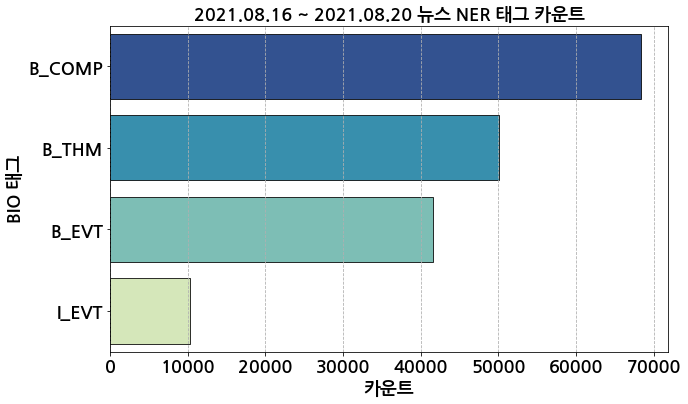

In [330]:
f, ax = plt.subplots(figsize = (10, 6))
ax.grid(axis='x', linestyle='--')

sns.countplot(y = "BIO_tag", data = NER_result, ax = ax, palette = "YlGnBu_r",edgecolor='black', linewidth=0.8,
             order=NER_result['BIO_tag'].value_counts().iloc[1:5].index)
plt.title("2021.08.16 ~ 2021.08.20 뉴스 NER 태그 카운트", size = 20, fontproperties = fontprop)
plt.xticks(size = 15, fontproperties = fontprop)
plt.yticks(size = 15, fontproperties = fontprop)
plt.xlabel("카운트", size = 18, fontproperties = fontprop)
plt.ylabel("BIO 태그", size = 18, fontproperties = fontprop)

In [335]:
result_EVT = NER_result.loc[(NER_result['BIO_tag'] == 'B_EVT') | (NER_result['BIO_tag'] == 'I_EVT')]
result_THM = NER_result.loc[(NER_result['BIO_tag'] == 'B_THM') | (NER_result['BIO_tag'] == 'I_THM')]

In [336]:
EVT_fillna = result_EVT.fillna(method='ffill', axis=0)

EVT_group = EVT_fillna.groupby(
['n_code', 'name'],as_index=False
)['token','BIO_tag'].agg(lambda x: list(x))

THM_fillna = result_THM.fillna(method='ffill', axis=0)

THM_group = THM_fillna.groupby(
['n_code', 'name'],as_index=False
)['token','BIO_tag'].agg(lambda x: list(x))

EVT_group.head()

,n_code,name,token,BIO_tag
0,000020,동화약품보통주,"[실적, 실적, 실적, 실적, 개선, 실적, 서비스, 국내, 공시, 자사주, 국내,...","[B_EVT, B_EVT, B_EVT, B_EVT, I_EVT, B_EVT, B_E..."
1,000060,메리츠화재해상보험보통주,"[실적, 국내, 실적, 실적, 수입, 공시, 공시, Mom, 배당, 수익, 일정]","[B_EVT, B_EVT, B_EVT, B_EVT, B_EVT, B_EVT, B_E..."
2,000070,삼양홀딩스보통주,"[국내, 임상, 해외, 임상, 증례, 확보, 기기, 해외, 국내, aging, 임상...","[B_EVT, B_EVT, B_EVT, B_EVT, B_EVT, I_EVT, I_E..."
3,000080,하이트진로보통주,"[신규, 신규, 실적, 실적, 뉴질랜드, 뉴질랜드, 해외, 확산, 뉴질랜드, 전략,...","[B_EVT, B_EVT, B_EVT, B_EVT, I_EVT, I_EVT, B_E..."
4,000100,유한양행보통주,"[국내, 국내, 안무, 국내, 국내, 안무, 국내, 국내, 안무, 국내, 국내, 진...","[B_EVT, B_EVT, I_EVT, B_EVT, B_EVT, I_EVT, B_E..."


# 테이블 추출 & 연관기업 병합

In [79]:
final_data = pd.read_csv('final_NER_data.csv')

In [80]:
final_data.head()

,id,n_code,name,token,BIO_tag,Word_idx,Tag_idx,drop_idx
0,text_0,049470,에스지에이,"['묻어두', '된다', '이종목', '사라', '두산중공업', '속주', '무조건...","['O', 'O', 'O', 'O', 'B_COMP', 'O', 'O', 'O', ...","[75007, 64674, 73106, 79124, 32314, 18717, 641...","[0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, ...",pass
1,text_1,026150,특수건설,"['특수건설', '확대', '특수건설', '확대', '전일', '거래', '특수',...","['B_COMP', 'O', 'B_COMP', 'O', 'O', 'O', 'O', ...","[62613, 17157, 62613, 17157, 56016, 66517, 460...","[5, 0, 5, 0, 0, 0, 0, 1, 0, 5, 5, 5, 5, 5, 5, ...",pass
2,text_100,017670,SK텔레콤보통주,"['5G', '집단', '소송', '변론', '기일', '열려', '소송인', 'S...","['B_THM', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '...","[37448, 33768, 70178, 77966, 27120, 9510, 6538...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",pass
3,text_1000,030210,케이티비투자증권보통주,"['장중', '수급', 'KTB', '기관', '연속', '뉴스핌', '로보', '...","['O', 'B_EVT', 'O', 'O', 'O', 'O', 'O', 'O', '...","[8857, 74736, 28621, 34622, 60233, 39810, 7050...","[0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",pass
4,text_1001,145020,휴젤,"['특징', '휴젤', '신세계', '인수', '추진', '강세', '신고', '이...","['O', 'B_COMP', 'B_COMP', 'B_EVT', 'I_EVT', 'O...","[49321, 43479, 3534, 45715, 36401, 82253, 2351...","[0, 5, 5, 4, 2, 0, 0, 0, 5, 5, 1, 4, 2, 0, 0, ...",pass


In [87]:
import ast 

def str_to_list(x):
    return ast.literal_eval(x)

final_data['token'] = final_data['token'].progress_apply(str_to_list)
final_data['BIO_tag'] = final_data['BIO_tag'].progress_apply(str_to_list)

100%|██████████| 155435/155435 [02:39<00:00, 975.74it/s] 


In [147]:
sep_token = []

for i in tqdm(range(len(final_data))):
    for j in range(200):
        try:
            text_id = 'text_{}'.format(i)
            n_code = final_data['n_code'][i]
            name= final_data['name'][i]
            token = final_data['token'][i][j]
            tag = final_data['BIO_tag'][i][j]
            
            token_data = text_id, n_code, name, token, tag
            sep_token.append(token_data)
        except:
            continue

100%|██████████| 155435/155435 [54:20<00:00, 47.68it/s] 


In [148]:
NER_result = pd.DataFrame(sep_token, columns = ['id','n_code', 'name', 'token', 'BIO_tag'])

In [150]:
NER_result.to_csv('NER_final_result.csv', index = False)

In [124]:
NER_result = pd.read_csv('NER_final_result.csv')

In [125]:
result_EVT = NER_result.loc[(NER_result['BIO_tag'] == 'B_EVT') | (NER_result['BIO_tag'] == 'I_EVT')]
result_THM = NER_result.loc[(NER_result['BIO_tag'] == 'B_THM') | (NER_result['BIO_tag'] == 'I_THM')]

In [126]:
result_EVT.reset_index(drop = True, inplace = True)
result_THM.reset_index(drop = True, inplace = True)

In [6]:
import multiprocessing as mp
from multiprocessing import Pool
import time
from itertools import product
from functools import partial

def B_I_EVT_merge(i):
    if result_EVT['BIO_tag'][i] == 'B_EVT' and result_EVT['BIO_tag'][i+1] == 'I_EVT':
        result_EVT['token'][i] = result_EVT['token'][i] + ' ' + result_EVT['token'][i+1]
    else:
        pass
       
    return result_EVT

           
if __name__ == '__main__':
    start = time.time()
    pool = Pool(processes=10)
    result = pool.map(B_I_EVT_merge, tqdm(range(0, len(result_EVT) - 1)))
    end = time.time()
    print("수행시간: %f 초" % (end - start))

100%|██████████| 754534/754534 [07:15<00:00, 1734.47it/s] 


수행시간: 583.235228 초


Process ForkPoolWorker-13:
Process ForkPoolWorker-19:
Process ForkPoolWorker-15:
Process ForkPoolWorker-14:
Process ForkPoolWorker-16:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-20:
Process ForkPoolWorker-11:
Process ForkPoolWorker-17:
Process ForkPoolWorker-18:
Process ForkPoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bo

In [961]:
result_EVT = result[0]
result_EVT.drop(result_EVT.loc[result_EVT['BIO_tag'] == 'I_EVT'].index, axis = 0, inplace = True)
result_EVT.reset_index(drop = True, inplace = True)
result_EVT.head()

In [962]:
def B_I_THM_merge(i):
    if result_THM['BIO_tag'][i] == 'B_THM' and result_THM['BIO_tag'][i+1] == 'I_THM':
        result_THM['token'][i] = result_THM['token'][i] + ' ' + result_THM['token'][i+1]
    else:
        pass
       
    return result_THM

           
if __name__ == '__main__':
    start = time.time()
    pool = Pool(processes=10)
    result = pool.map(B_I_THM_merge, tqdm(range(0, len(result_THM) - 1)))
    end = time.time()
    print("수행시간: %f 초" % (end - start))

In [131]:
result_THM = result[0]
result_THM.drop(result_THM.loc[result_THM['BIO_tag'] == 'I_THM'].index, axis = 0, inplace = True)
result_THM.reset_index(drop = True, inplace = True)

In [96]:
from collections import Counter

c = Counter(result_THM['token'])
most_THEME = c.most_common(5)

most_THEME = pd.DataFrame(most_THEME, columns = ["단어 토큰", "빈도 수"])

In [119]:
c = Counter(bigram_EVT['token'])
most_EVT = c.most_common(5)
most_EVT = pd.DataFrame(most_EVT, columns = ["단어 토큰", "빈도 수"])

In [819]:
most_THEME

,단어 토큰,빈도 수
0,코로나19,34330
1,반도체,28504
2,바이오,23057
3,백신,22620
4,배터리,17912


In [120]:
palette = [(0.999078431372549, 0.8565974625144174, 0.31494809688581313),(0.16696655132641292, 0.48069204152249134, 0.7291503267973857)]

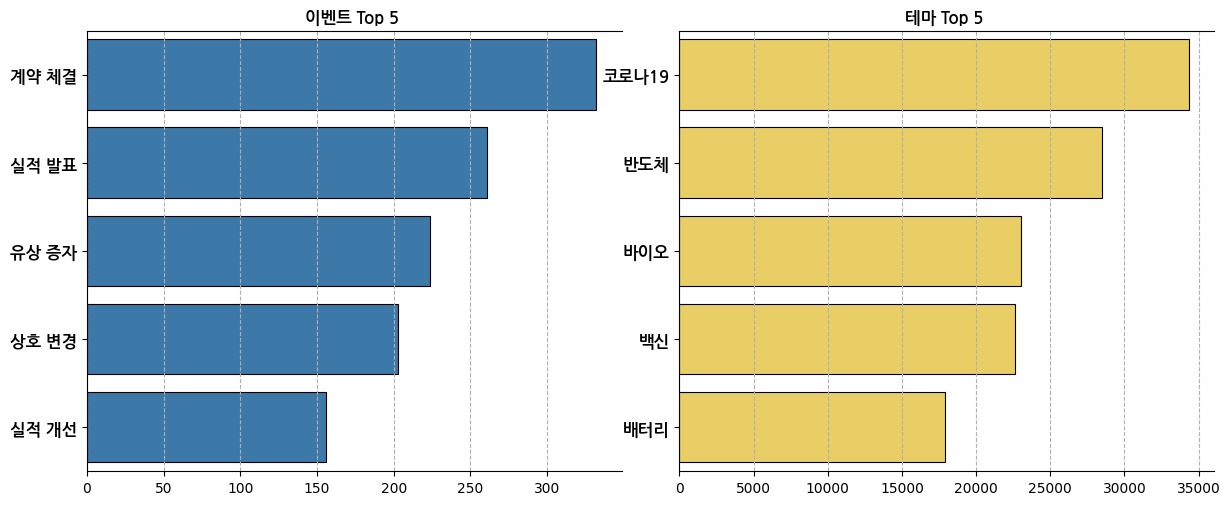

In [121]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), dpi=100)
axes[0].grid(axis='x', linestyle='--')
axes[1].grid(axis='x', linestyle='--')
plt.tight_layout()

sns.barplot(y=most_EVT['단어 토큰'].values, x=most_EVT['빈도 수'].values, ax=axes[0], edgecolor='black', linewidth=0.8,color=palette[1])
sns.barplot(y=most_THEME['단어 토큰'].values, x=most_THEME['빈도 수'].values, ax=axes[1], edgecolor='black', linewidth=0.8,color=palette[0])

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
axes[0].set_yticklabels(most_EVT['단어 토큰'].values, fontproperties = fontprop)
axes[1].set_yticklabels(most_THEME['단어 토큰'].values, fontproperties = fontprop)
axes[0].set_title('이벤트 Top 5 ', fontproperties = fontprop)
axes[1].set_title('테마 Top 5 ', fontproperties = fontprop)

plt.show()

# Sample data 추출 (이벤트, 테마)

In [22]:
EVT_fillna = result_EVT.fillna(method='ffill', axis=0)

EVT_group = EVT_fillna.groupby(['name'],as_index=False)['token','BIO_tag'].agg(lambda x: list(set(x)))

In [585]:
THM_fillna = result_THM.fillna(method='ffill', axis=0)

THM_group = THM_fillna.groupby(['name'],as_index=False)['token','BIO_tag'].agg(lambda x: list(x))

In [589]:
for x in tqdm(range(len(THM_group['token']))):
    for i in THM_group['token'][x]:
        if THM_group['token'][x].count(str(i)) < 50:
            THM_group['token'][x].remove(str(i))
            
        else:
            continue

100%|██████████| 2259/2259 [01:42<00:00, 22.00it/s] 


In [627]:
# 코스피 TOP 10

sample_list = ['삼성전자보통주', '에스케이하이닉스보통주', 'NAVER보통주', '카카오보통주', '삼성바이오로직스보통주',
'LG화학보통주', '삼성SDI보통주', '현대자동차보통주', '셀트리온보통주', '기아보통주', '엔에이치투자증권보통주']

sample_df_list = []

for i in sample_list:
    sample_df_list.append(THM_group.loc[THM_group['name'] == i])
    
sample_THM = pd.concat(sample_df_list)    

In [629]:
sample_THM.reset_index(drop = True, inplace = True)

In [631]:
sep_token = []

for i in tqdm(range(len(sample_THM))):
    for j in range(40000):
        try:
            name= sample_THM['name'][i]
            token = sample_THM['token'][i][j]
            
            token_data = name, token
            sep_token.append(token_data)
        except:
            pass

100%|██████████| 11/11 [00:24<00:00,  2.20s/it]


In [931]:
sep_token = []

for i in tqdm(range(len(sample_data))):
    for j in range(40000):
        try:
            name= sample_data['name'][i]
            token = sample_data['EVENT'][i][j]
            
            token_data = name, token
            sep_token.append(token_data)
        except:
            pass

100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


In [933]:
sample_EVT = pd.DataFrame(sep_token, columns = ['name', 'token'])

In [937]:
sample_EVT.head()

,name,token
0,삼성전자보통주,계약 수주
1,삼성전자보통주,일정 공개
2,삼성전자보통주,배당 결정
3,삼성전자보통주,수출
4,삼성전자보통주,계약 체결


In [939]:
# 감성 스코어 태깅을 위해 unique값 분류

pos_list = ['계약 수주' ,'일정 공개' ,'배당 결정','수출','계약 체결','실적 확산', 
            '서비스 시작','실적 공개','수급 개선','협약 체결','실적 달성' ,'서비스 강화',
            '호황' ,'실적 개선','이벤트','수익 개선','협약','성과','출시',
            '임상','특허','수익 공개','국내 판매','공장 결정','초호황', 'MOU',
            '전략 합병','서비스 추진','진출','계약' ,'공급','MOU 체결' ,'흥행' ,
            '실적 발표','대호황' ,'공급 예정','수익','수입','출시 예정','신규 추진',
            '전략 제휴','해외 상장','서비스 확대','서비스 확산' ,'인수 추진','국내 상장',
            '협약 시작','수익 확보', '코스피 상장', '공장 수주', '공장 신설', '전략 발표', '공급 확대',
            '실적 확대', '공급 증가', '공급 시작', '출시 시작', '실적 판매', '배당 실시', '협약 추진', '해외 판매',
            '성과 달성', '공급 체결', '계약 판매', '일정 확정', '출시 확정', '수익 확대', '수출 증가', '해외 증가',
            '흥행 성공', '출시 판매']

neg_list = ['출시 규제', '수익 영향', '실적 악화', '인수 합병', '실적 부진', '상호 변경', '유상 증자', '흡수',
           '분할 결정', '흡수 합병', '수급 악화', '수급 문제', '일정 지연', '국내 영향', '공급 문제', '국내 감소',
           '해외 확산', '출시 지연']

In [941]:
def sentiment_labeling(x):
    if x in pos_list:
        return 'positive'
    elif x in neg_list:
        return 'negative'
    else:
        return 'drop'
    
sample_EVT['word_sentiment'] = sample_EVT['token'].progress_apply(sentiment_labeling)

100%|██████████| 490/490 [00:00<00:00, 143480.10it/s]


In [943]:
sample_EVT.drop(sample_EVT.loc[sample_EVT['word_sentiment'] == 'drop'].index, axis = 0, inplace = True)

In [935]:
count_EVT = pd.DataFrame(sample_EVT.groupby(['name', 'token'])['token'].count())

In [946]:
sample_EVT.to_csv('sample_EVT_sentiment.csv')

In [675]:
count_thm.columns = ['_'.join(col).strip() for col in count_thm.columns.values]

In [963]:
sample_EVT.head()

,name,token,word_sentiment
0,삼성전자보통주,계약 수주,positive
1,삼성전자보통주,일정 공개,positive
2,삼성전자보통주,배당 결정,positive
3,삼성전자보통주,수출,positive
4,삼성전자보통주,계약 체결,positive


In [636]:
sample_THM.to_csv('theme_wordcloud.csv')

In [141]:
def set_list(x):
    return list(set(x))

THM_group['token'] = THM_group['token'].progress_apply(set_list)

100%|██████████| 2259/2259 [00:00<00:00, 45508.80it/s]


In [144]:
iem_data.rename({'stk_iem_krl_nm':'name'}, axis = 1, inplace = True)

In [145]:
EVT_group.rename({'token':'EVENT'}, axis = 1, inplace = True)
THM_group.rename({'token':'THEME'}, axis = 1, inplace = True)

EVT_THM = pd.merge(EVT_group, THM_group, on = 'name')

In [146]:
EVT_THM = pd.merge(iem_data, EVT_THM, on = 'name')

In [147]:
EVT_THM = EVT_THM[['n_code', 'name', 'EVENT', 'THEME']]

In [198]:
EVT_THM.to_csv('EVT_THM_COMP.csv', index = False)

In [150]:
COMP = pd.read_csv('linked_comp.csv')

In [175]:
COMP.drop(COMP.loc[COMP['관련기업리스트'] == '기업정보없음'].index, axis = 0, inplace = True)

In [178]:
COMP.reset_index(drop = True, inplace = True)

In [179]:
for i in tqdm(range(len(COMP))):
    idx = EVT_THM.loc[EVT_THM['name'].str.contains(COMP['기업명'][i])].index
    EVT_THM['LINKED_COMP'][idx] = COMP['관련기업리스트'][i]

100%|██████████| 2051/2051 [00:07<00:00, 256.48it/s]


In [213]:
sample_list = ['삼성전자보통주', '에스케이하이닉스보통주', 'NAVER보통주', '카카오보통주', '삼성바이오로직스보통주',
'LG화학보통주', '삼성SDI보통주', '현대자동차보통주', '셀트리온보통주', '기아보통주']

In [215]:
sample_df_list = []

for i in sample_list:
    sample_df_list.append(EVT_THM.loc[EVT_THM['name'] == i])
    
sample_data = pd.concat(sample_df_list)    

In [217]:
sample_data.reset_index(drop= True, inplace = True)

In [909]:
sample_data.to_csv('sample_data_EVT_THM_COMP.csv', index = False)

# 연관어 추출

In [685]:
!pip install soykeyword

Looking in indexes: http://172.20.8.21:8081/repository/pypi-repo/simple


In [686]:
metadata = pd.read_csv('new_metadata.csv')
metadata.head()

,form,n_code,n_content,n_content_clean,n_date,n_title,rgs_mkt_cd,stk_iem_krl_nm,title_content,title_content_clean,month,day,dayofweek
0,news,046940,"우원개발(046940)이 상승폭을 확대하고 있다. 전일 대비 4.40% 상승한 7,...","우원개발(046940)이 상승폭을 확대하고 있다. 전일 대비 4.40% 상승한 7,...",2021-07-15,"우원개발, +4.40% 상승폭 확대",코스닥,우원개발,"우원개발, +4.40% 상승폭 확대. 우원개발(046940)이 상승폭을 확대하고 있...",우원개발 4.40 상승폭 확대. 우원개발 046940 이 상승폭을 확대하고 있다. ...,7,15,3
1,news,046940,"<meta http-equiv=""Content-Type"" content=""text/...","<meta http-equiv=""Content-Type"" content=""text/...",2021-07-15,우원개발(046940) 소폭 상승세 +3.06%,코스닥,우원개발,우원개발(046940) 소폭 상승세 +3.06%. <meta http-equiv=...,우원개발 046940 소폭 상승세 3.06 . 제목 우원개발 046940 소폭 상승...,7,15,3
2,news,046940,"<meta http-equiv=""Content-Type"" content=""text/...","<meta http-equiv=""Content-Type"" content=""text/...",2021-06-30,우원개발(046940) 소폭 상승세 +3.13%,코스닥,우원개발,우원개발(046940) 소폭 상승세 +3.13%. <meta http-equiv=...,우원개발 046940 소폭 상승세 3.13 . 제목 우원개발 046940 소폭 상승...,6,30,2
3,news,046940,"<meta http-equiv=""Content-Type"" content=""text/...","<meta http-equiv=""Content-Type"" content=""text/...",2021-07-27,우원개발(046940) 소폭 상승세 +3.17%,코스닥,우원개발,우원개발(046940) 소폭 상승세 +3.17%. <meta http-equiv=...,우원개발 046940 소폭 상승세 3.17 . 제목 우원개발 046940 소폭 상승...,7,27,1
4,news,046940,"<meta http-equiv=""Content-Type"" content=""text/...","<meta http-equiv=""Content-Type"" content=""text/...",2021-06-02,"우원개발(046940) 소폭 상승세 +3.12%, 3거래일 연속 상승",코스닥,우원개발,"우원개발(046940) 소폭 상승세 +3.12%, 3거래일 연속 상승. <meta...",우원개발 046940 소폭 상승세 3.12 3거래일 연속 상승. 제목 우원개발 04...,6,2,2


In [810]:
metadata.shape

(134719, 13)

In [687]:
def tokenizing_for_count(x):
    x = mecab.nouns(x)
    x = remove_stopwords(x)
    x = remove_onewords(x)
    return x

In [691]:
%%time

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0.001, ngram_range = (1, 1), tokenizer = tokenizing_for_count)
x = vectorizer.fit_transform(metadata['title_content_clean'])

CPU times: user 6min 9s, sys: 4.21 s, total: 6min 13s
Wall time: 6min 13s


In [811]:
x

<134719x6338 sparse matrix of type '<class 'numpy.int64'>'
	with 7693712 stored elements in Compressed Sparse Row format>

In [692]:
word2index = vectorizer.vocabulary_
index2word = sorted(
    vectorizer.vocabulary_,
    key=lambda x:vectorizer.vocabulary_[x]
)

In [756]:
%%time

from soykeyword.proportion import MatrixbasedKeywordExtractor

matrixbased_extractor = MatrixbasedKeywordExtractor(
    min_tf=10,
    min_df=3,
    verbose=True
)

matrixbased_extractor.train(x, index2word)

MatrixbasedKeywordExtractor trained
CPU times: user 58.8 s, sys: 1.84 s, total: 1min
Wall time: 1min


In [874]:
keywords = matrixbased_extractor.extract_from_word(
    '기아',
    min_score=0.0,
    min_frequency=1000)

keywords[:21]

[KeywordScore(word='기아', frequency=8872, score=1.0),
 KeywordScore(word='신차', frequency=1379, score=0.9580323481078163),
 KeywordScore(word='현대차', frequency=14449, score=0.9493384027751619),
 KeywordScore(word='하이브리드', frequency=1624, score=0.9465819104398148),
 KeywordScore(word='신형', frequency=1124, score=0.9427565407530044),
 KeywordScore(word='신한지주', frequency=1415, score=0.9390612883230753),
 KeywordScore(word='현대모비스', frequency=2545, score=0.9353942723676978),
 KeywordScore(word='제네시스', frequency=1239, score=0.932076041940814),
 KeywordScore(word='명예', frequency=1391, score=0.9258501075611469),
 KeywordScore(word='사양', frequency=1049, score=0.9252923000447014),
 KeywordScore(word='전동', frequency=1211, score=0.9234569218994929),
 KeywordScore(word='주행', frequency=2534, score=0.9227754861159873),
 KeywordScore(word='현대위아', frequency=1446, score=0.922327357500143),
 KeywordScore(word='하이텍', frequency=1652, score=0.9147667525585946),
 KeywordScore(word='교섭', frequency=1587, score=0.9

In [875]:
# keyword_list_n 리스트 차례로 적재 (for loop 추가 필요)

keyword_list_10 = []

for words in keywords[1:21]:
    token = words.word
    frequency = words.frequency
    score = words.score
    keyword_data = token, frequency, score
    
    keyword_list_10.append(keyword_data)

In [876]:
kia = pd.DataFrame(keyword_list_10, columns = ['linked_words', 'freq', 'score'])

In [896]:
sample_linked_word_data = pd.concat([sample_linked_word_data, kia], axis = 0)    

In [898]:
sample_linked_word_data.to_csv('sample_linked_word_data.csv', index = False)